In [1]:
import os,sys,signal
import math

import pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting

import musicnet

from time import time

from sklearn.metrics import average_precision_score

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='0'

import torch
from torch.nn.functional import conv1d, mse_loss
import torch.nn.functional as F
import torch.nn as nn

if torch.cuda.is_available():
    device = "cuda:0"
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
# Network Parameters
epochs = 20
train_size = 100000
test_size = 50000

lr = 1e-6
momentum = .95

pitch_shift = 0
jitter = 0.
num_workers = 10
sequence = 1

# lvl1 convolutions are shared between regions
m = 128
k = 512              # lvl1 nodes
n_fft = 4096              # lvl1 receptive field
window = 16384 # total number of audio samples?
stride = 512
batch_size = 100

regions = 1 + (window - n_fft)//stride

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers
kwargs = {'num_workers': num_workers, 'pin_memory': True, 'worker_init_fn': worker_init}

In [3]:
# function for returning scientific notation in a plot
def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return fr'${a} \times 10^{{{b}}}$'

In [4]:
result_dict = {'loss_history_train': [],
               'avgp_history_train': [],
               'loss_history_test': [],
               'avgp_history_test': [],
               'parameters': {}}

result_dict['parameters']['train_size'] = train_size
result_dict['parameters']['test_size'] = test_size
result_dict['parameters']['lr'] = lr
result_dict['parameters']['pitch_shift'] = pitch_shift
result_dict['parameters']['jitter'] = jitter

# Preparing Dataset

In [5]:
start = time()
root = './data/'
train_set = musicnet.MusicNet(root=root, epoch_size=train_size,sequence=sequence
                              , train=True, download=True, refresh_cache=False, 
                              window=window, mmap=False, pitch_shift=pitch_shift, jitter=jitter)
test_set = musicnet.MusicNet(root=root, train=False, download=True,sequence=sequence
                             , refresh_cache=False, window=window, epoch_size=test_size, mmap=False)
print("Data loaded, time used = {:2.2f} seconds".format(time()-start))

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

Data loaded, time used = 28.12 seconds


# Defining Models

In [6]:
Loss = torch.nn.MSELoss()
def L(yhatvar,y):
    return Loss(yhatvar,y) * 128/2

In [7]:
class Model(torch.nn.Module):
    def __init__(self, avg=.9998):
        super(Model, self).__init__()
        # Create filter windows for stft
        wsin, wcos = musicnet.create_filters(n_fft,k, windowing="no", freq_scale='linear')
        self.wsin = torch.tensor(wsin, dtype=torch.float)
        self.wcos = torch.tensor(wcos, dtype=torch.float)
            
        # Creating Layers
        self.linear = torch.nn.Linear(regions*k, m)
        torch.nn.init.constant_(self.linear.weight, 0) # initialize
        
        self.avg = avg
        
    def forward(self,x):
        zx = conv1d(x[:,None,:], self.wsin, stride=stride).pow(2) \
           + conv1d(x[:,None,:], self.wcos, stride=stride).pow(2) # Doing STFT by using conv1d
        return self.linear((zx).view(x.data.size()[0],regions*k))
    

In [8]:
model = Model()
model.to(device)

Model(
  (linear): Linear(in_features=12800, out_features=128, bias=True)
)

In [9]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# optimizer = SWA(base_opt, swa_start=0, swa_freq=1, swa_lr=0.000001)

try:
    with train_set, test_set:
        print("epoch\ttrain loss\ttest loss\ttrain avg\ttest avg\ttime\tutime")
        for e in range(epochs):
            yground = torch.Tensor(batch_size*len(train_loader), m) # what not do this together with loss
            yhat = torch.Tensor(batch_size*len(train_loader), m)
            avgp, loss_e = 0.,0
            t = time()
            for i, (x,y) in enumerate(train_loader):
                print(f"training {i}/{len(train_loader)} batches", end = '\r')
                optimizer.zero_grad()
                
                # making x and y into pytorch dealable format
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                yhatvar = model(x)
                loss = L(yhatvar,y)
                loss.backward()
                loss_e += loss.item() #getting the number
                
                yground[i*batch_size:(i+1)*batch_size] = y.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data
                
                optimizer.step()
            avgp = average_precision_score(yground.cpu().flatten(),yhat.cpu().flatten())  
            
            result_dict['loss_history_train'].append(loss_e/len(train_loader))
            result_dict['avgp_history_train'].append(avgp)   
            t1 = time()
            avgp, loss_e = 0.,0.           
#             optimizer.swap_swa_sgd() # change to average weight
            
            # For testing
            yground = torch.Tensor(batch_size*len(test_loader), m) # what not do this together with loss
            yhat = torch.Tensor(batch_size*len(test_loader), m)
            
            for i, (x_test,y_test) in enumerate(test_loader):
                print(f"testing {i}/{len(test_loader)} batches", end = '\r')
                x_test = x_test.to(device)
                y_test = y_test.to(device)
                yhatvar = model(x_test)
                loss_e += L(yhatvar, y_test).item() #getting the number

                yground[i*batch_size:(i+1)*batch_size] = y_test.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data
            avgp = average_precision_score(yground.cpu().flatten(),yhat.cpu().flatten())
            result_dict['loss_history_test'].append(loss_e/len(test_loader))
            result_dict['avgp_history_test'].append(avgp)
            print('{}\t{:2f}\t{:2f}\t{:2f}\t{:2f}\t{:2.1f}\t{:2.1f}'.\
                  format(e,
                         result_dict['loss_history_train'][-1],result_dict['loss_history_test'][-1],
                         result_dict['avgp_history_train'][-1],result_dict['avgp_history_test'][-1],
                         time()-t, time()-t1))


        
except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print("Finsihed")
    

epoch	train loss	test loss	train avg	test avg	time	utime
0	1.266088	1.048057	0.318108	0.299974	21.6	7.0
1	1.259711	1.074205	0.326555	0.299252	21.5	7.0
2	1.264954	1.068243	0.325067	0.303055	21.4	7.0
3	1.265122	1.039353	0.325071	0.314474	21.6	7.0
4	1.260707	1.058408	0.324873	0.301860	21.7	7.1
5	1.262097	1.085196	0.324038	0.294368	21.6	6.9
6	1.266452	1.076154	0.324160	0.297046	21.7	7.1
7	1.260044	1.051712	0.326067	0.303649	21.6	7.0
8	1.262410	1.063127	0.326459	0.308729	21.7	7.0
9	1.265728	1.050449	0.324776	0.302934	22.7	7.8
10	1.261576	1.061122	0.326591	0.312342	23.7	8.5
11	1.280859	1.076218	0.322481	0.307470	24.0	8.3
12	1.266517	1.087863	0.324669	0.299351	23.3	7.2
13	1.260341	1.050296	0.325769	0.306560	21.5	7.0
14	1.255645	1.052574	0.327075	0.305986	21.7	7.2
15	1.263872	1.090365	0.324296	0.287043	22.2	7.3
16	1.261020	1.050697	0.325519	0.308548	22.7	7.1
17	1.261519	1.088344	0.327695	0.276896	21.6	7.1
18	1.268011	1.070825	0.324447	0.295673	21.9	7.0
19	1.261648	1.058387	0.326999	0.302476	19

(0.3, 0.8)

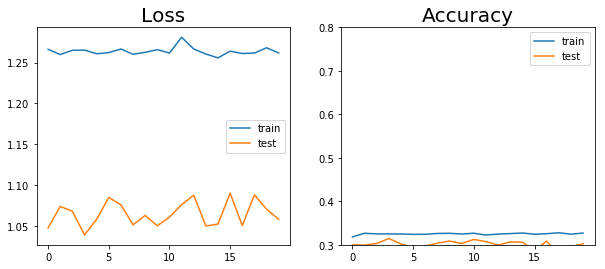

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(result_dict['loss_history_train'])
ax[0].plot(result_dict['loss_history_test'])
ax[0].legend(['train', 'test'])
ax[0].set_title('Loss', size=20)

ax[1].plot(result_dict['avgp_history_train'])
ax[1].plot(result_dict['avgp_history_test'])
ax[1].legend(['train', 'test'])
ax[1].set_title('Accuracy', size=20)
ax[1].set_ylim(0.3,0.80)

# Mir_Eval stats

In [11]:
print('AvgP\tP\tR\tAcc\tETot\tESub\tEmiss\tEfa')
Accavg = 0
Etotavg = 0
for songid in test_set.rec_ids:
    Y_pred, Y_true = musicnet.get_piano_roll(songid, test_set, model,
                                             window=window, m=m, stride=-1)
    Yhatpred = Y_pred > 0.4
    _,_,_,Acc,Etot = musicnet.get_mir_accuracy(Y_pred, Y_true, m=m)
    Accavg += Acc
    Etotavg += Etot

AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
35.70	56.76	22.56	0.19	0.80	0.14	0.63	0.03
30.04	48.33	27.13	0.21	0.85	0.17	0.56	0.12
18.89	31.84	14.56	0.11	1.02	0.15	0.71	0.16
33.93	43.73	36.82	0.25	0.93	0.18	0.45	0.29
44.15	42.77	51.41	0.30	0.94	0.23	0.25	0.46
24.83	30.81	38.20	0.21	1.10	0.38	0.24	0.48
26.58	43.03	18.61	0.15	0.87	0.19	0.62	0.06
34.02	51.34	25.39	0.20	0.82	0.16	0.58	0.08
34.67	44.93	28.29	0.21	0.90	0.16	0.56	0.18
35.33	49.90	21.18	0.17	0.85	0.15	0.64	0.06


In [12]:
print('Average Accuracy: \t{:2.2f}\nAverage Error: \t\t{:2.2f}'\\
      .format(Accavg/len(test_set.rec_ids)*100, Etotavg/len(test_set.rec_ids)*100))

SyntaxError: unexpected character after line continuation character (<ipython-input-12-ad5b974cadcf>, line 1)

# Saving weights and results

In [ ]:
torch.save(model.state_dict(), './weights/spectrograms_nocompress')
with open('./result_dict/spectrograms_nocompress', 'wb') as f:
    pickle.dump(result_dict, f)